TODO:
Code
- Michaelis-Menten for glucose
- invertase production based on compounds
- Growth phase (log etc.) Gompertz eq

Models
- Cross correlation of peaks? Like molecular time sharing paper
- Summary graphs of total invertase / melatonin / glucose in grid 

Look into
- Markov Chain Monte Carlo (MCMC)
- “nonlinear mixed-effects models” (NMEMs) (Davidian & Giltinan, 2003)
- observation variables and the state variables
- cell cell coupling https://www.slcu.cam.ac.uk/people/jonsson-henrik
- Heterogeneity within cell culture affecting stability etc.

In [2]:
#@title Installations
!pip install perlin_noise
!pip install noise
!pip install array2gif
# !pip install cupy==9.0.0

In [3]:
#@title Imports
# import pkg_resources
# pkg_resources.require("cupy==9.0.0")   # For interp

from perlin_noise import PerlinNoise
from noise import snoise2

import time
from copy import deepcopy
from datetime import datetime
from pathlib import Path
import glob
from PIL import Image
import os

import numpy as np
# import cupy as np
# from numba import jit
from numba import vectorize 
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import seaborn as sns
import pandas as pd
import skimage.filters.rank
import skimage.morphology
import imageio

from google.colab import drive
from google.colab import files
drive.mount("/content/gdrive")

plt.style.use('seaborn')
%matplotlib inline



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
#@title Arbitrary HP's 

grid_size = 200
num_dimensions = 2
grid_dimensions = [grid_size] * num_dimensions

initial_producer_density = 0.0001 * 2
initial_sensor_density = initial_producer_density

# Names
sensor = 'sensor'
producer_A = 'H2 (low)'
producer_B = 'H5 (medium)'
producer_C = 'H4 (high)'

initial_producer_density = 0.002
initial_sensor_density = initial_producer_density
cell_type_info = {
    sensor: [
             initial_sensor_density,    # Cell Density
             (90 * 60),                 # Doubling time (sec)
             0],                        # Producer strength
    producer_A: [
                 initial_producer_density,
                 (90 * 60),
                 0.0000000148310251434],
    producer_B: [
                 initial_producer_density,
                 (90 * 60),
                 0.000000595353313081],
    producer_C: [
                 initial_producer_density,
                 (90 * 60),
                 0.0000211020342857]
}
cell_type_info["null"] = [
                          1 - sum([i[0] for i in cell_type_info.values()]), 
                          0,
                          0]

perlin_noise_octaves = {16: 0.25}   # 4: 0.2, 8: 0.5, 

# initial_noise_textures
# initial_distribution = 'normal'


In [5]:
#@title Important variables

# Population rates
k_growth_p = 0        # producer
k_growth_s = 0        # sensor
k_growth_p_gluc = 0
k_growth_s_gluc = 0

# Melatonin
k_mel_script = 0
k_mel_slate = 0
d_mel = 0
k_mel_secretion = 0
d_mel_secreted = 0

# Sensor
k_gpcr_bind = 0 

k_suc_script = 0
k_suc_slate = 0
k_suc_secretion = 0
d_suc_in = 0
d_suc_out = 0

k_gfp_script = 0
k_gfp_slate = 0
d_gfp = 0

# Rewarding
sucrose_conc = 1
k_suc_glucose = 0*sucrose_conc   # Rate sucrose hydrolysis to glucose
# Replace these with growth curves:
k_gluc_intake_s = 0         # Sensor
k_gluc_intake_p = 0         # Producer

In [6]:
# @title Class: Base Grid 
class Base_grid():
    def __init__(self):
        self.gif_directory = ''
        self.output_dir = './'
        self.np_dtype = np.float32
        self.date = datetime.now().strftime("%Y_%m_%d-%I%M%S")
        self.root_save_folder = '/content/gdrive/MyDrive/FYP_colab_outputs'

    # Decorators
    @staticmethod
    def timer(func):
        '''Decorator that reports the execution time.'''
    
        def wrap(*args, **kwargs):
            start = time.time()
            result = func(*args, **kwargs)
            end = time.time()
            
            print("Function {} took".format(func.__name__), end-start)
            return result
        return wrap

    # Helpers
    def animator(self, gif_name='cell_grid'):
        """ Animate numpy array """

        self.gif_save_name = '{}/{}_{}.gif'.format(self.output_dir, gif_name, self.date, self.cell_seed_iter)
        frame_rate = 5     # fps
        
        frames = []
        imgs = glob.glob("./{}/*.png".format(self.gif_directory))
        imgs.sort()

        for i in imgs:
            new_frame = Image.open(i)
            frames.append(new_frame)

        # Save into a GIF file that loops forever
        frames[0].save(self.gif_save_name, format='GIF',
                       append_images=frames[1:],
                       save_all=True,
                       duration=(len(frames)/frame_rate), loop=1)
        
    def exclude_keys(self, d, excluded_keys, return_type='values'):
        if return_type == 'values':
            return [x for k, x in d.items() if k not in excluded_keys]
        elif return_type == 'keys':
            return [x for x in d.keys() if x not in excluded_keys]
        else:
            return {k: x for k, x in d.items() if k not in excluded_keys}
    
    def play_gif(self, fname=None, url=None):
        from IPython.display import Image as pyImage
        if url:
            !wget url
        if fname==None:
            fname = self.gif_save_name
        pyImage(open(fname,'rb').read())

    def reset(self):
        Path(self.gif_directory).mkdir(parents=True, exist_ok=True)
        Path(self.output_dir).mkdir(parents=True, exist_ok=True)

        rem_files = glob.glob('./{}/*'.format(self.gif_directory))
        for f in rem_files:
            os.remove(f)

    def visualise_grid(self, grid, title_text='', opt_text='', opt_cbar_text='Co-growth', show=True, save_name='', quantised=False, opt_cbar_tickers=''):
        plt.style.use('default')

        grid_max = np.max(grid)
        num_colors = grid_max+1

        fig = plt.figure()
        ax = fig.add_subplot()
        ax.set_title(opt_text)
        cmap = plt.get_cmap('viridis', num_colors) if quantised else plt.get_cmap('viridis')

        fig.subplots_adjust(right=0.85)
        plt.title(title_text)
        im = ax.imshow(grid.copy(), cmap=cmap, vmin=0, vmax=grid_max)
        cbar = fig.colorbar(im)
        if quantised:
            bounds = np.array(range(0, num_colors)) * (1-1/grid_max)
            cbar.set_ticks(np.array(bounds)+0.5)
            tick_texts = cbar.ax.set_yticklabels(opt_cbar_tickers)
            tick_texts[0].set_verticalalignment('top')
            tick_texts[-1].set_verticalalignment('bottom')
        cbar.ax.set_xlabel(opt_cbar_text, labelpad=20)

        if show:
            print('Visualising...', opt_text)
            plt.show()
        else:
            plt.savefig('./{}/{}'.format(self.gif_directory, save_name))
            plt.close(fig)

    def visualise_grids(self, grids, opt_text=''):
        assert type(grids) == dict, "To visualise multiple grids, make sure they are passed as dict"

        for molec, grid in grids.items():
            self.visualise_grid(grid, opt_text=molec, opt_cbar_text=molec)

    def visualise_grids_together(self, grids, rows, cols, quantised, title_text='', opt_text='', opt_cbar_text='Co-growth', show=True, save_name='', opt_cbar_tickers=''):
        plt.style.use('default')

        assert len(rows) == len(grids), "The number of grids passed does not match number of indices passed."

        nrows = np.max(rows)
        ncols = np.max(cols)
        fig = plt.figure(figsize=(15, 8))
        for i, (grid, quant) in enumerate(zip(grids, quantised)):

            grid_max = np.max(grid)
            num_colors = grid_max+1

            ax = fig.add_subplot(nrows, ncols, i+1)
            ax.set_title(opt_text)
            cmap = plt.get_cmap('viridis', num_colors) if quant else plt.get_cmap('viridis')

            # fig.subplots_adjust(right=0.85)
            im = ax.imshow(grid.copy(), cmap=cmap, vmin=0, vmax=grid_max)
            cbar = fig.colorbar(im)
            if quant:
                bounds = np.array(range(0, num_colors)) * (1-1/grid_max)
                cbar.set_ticks(np.array(bounds)+0.5)
                tick_texts = cbar.ax.set_yticklabels(opt_cbar_tickers)
                tick_texts[0].set_verticalalignment('top')
                tick_texts[-1].set_verticalalignment('bottom')
            cbar.ax.set_xlabel(opt_cbar_text, labelpad=20)

        plt.suptitle(title_text)
        if show:
            print('Visualising...', opt_text)
            plt.show()
        else:
            plt.savefig('./{}/{}'.format(self.gif_directory, save_name))
            plt.close(fig)

    # Grid Functions
    def get_cell_counts(self, grid):
        total_counts = {x: 0 for x in self.all_identities.keys()}
        for i, key in enumerate(total_counts.keys()):
            total_counts[key] = np.sum(np.where( grid == i ))
        return total_counts

    def get_diffuse_grid(self, grid_dimensions, noise_type="normal", noise_seed=1):
        if noise_type == "perlin":
            grid = np.array(self.get_perlin_texture(grid_dimensions, noise_seed), dtype=self.np_dtype)
        else:
            grid = np.array(self.get_normal_texture(grid_dimensions), dtype=self.np_dtype)
        return grid

    def get_empty_grid(self, grid_dimensions):
        return np.zeros(grid_dimensions, dtype=self.np_dtype)

    def get_quant_grid(self, grid_dimensions, densities, noise_type="perlin", noise_seed=1):
        """ Initialise the grid with each cell type in certain spatial distributions, 
        eg Perlin noise or normal distributions. """

        get_texture = self.get_perlin_texture if noise_type == "perlin" else self.get_normal_texture
        texture = get_texture(grid_dimensions, noise_seed)

        # Scale to 1
        final_density = np.sum(np.array([i for i in densities.values()]))
        if not (final_density == 1): print('Initial densities do not add to 1')

        grid = self.get_empty_grid(grid_dimensions)
        cumul_density = 0
        for i, density in enumerate(densities.values()):
            # Normalise to 1
            density = density / final_density
            # print('index ' + str(i+1) + ' density: ' + str(density) + ' cumul_density: ' + str(cumul_density))
            grid += ((texture >= cumul_density) & (texture <= (cumul_density+density))) * int(i)
            cumul_density += density
        
        return np.array(grid, dtype=np.uint8)

    def get_normal_texture(self, grid_dimensions, new_seed=0):
        np.random.seed(new_seed)
        if self.dimensionality == 2:
            texture = np.random.rand(grid_dimensions[0], grid_dimensions[1])
        elif self.dimensionality == 3:
            texture = np.random.rand(grid_dimensions[0], grid_dimensions[1], grid_dimensions[2])
        texture = np.interp(texture, np.array([texture.min(), texture.max()]), np.array([0, 1]))
        return texture

    def get_perlin_texture(self, grid_dimensions, new_seed=0):
        noises = []
        for octave in self.perlin_noise_octaves.keys():
            noise = PerlinNoise(octaves=octave, seed=new_seed)
            noises.append(noise)

        disc_noises = []
        if self.dimensionality == 3:
            xpix, ypix, zpix = grid_dimensions
            for bias, noise in zip(self.perlin_noise_octaves.values(), noises):
                disc_noise = [[[bias * noise([i/xpix, j/ypix, k/zpix]) for j in range(xpix)] for i in range(ypix)] for k in range(zpix)]
                disc_noises.append(disc_noise)
        elif self.dimensionality == 2:
            xpix, ypix = grid_dimensions
            for (octave, bias), noise in zip(self.perlin_noise_octaves.items(), noises):
                if self.use_snoise:
                    disc_noise = [[bias * snoise2(i/xpix, j/ypix, octave) for j in range(xpix)] for i in range(ypix)]                
                else:
                    disc_noise = [[bias * noise([i/xpix, j/ypix]) for j in range(xpix)] for i in range(ypix)]
                disc_noises.append(disc_noise)

        texture = disc_noises[0]
        if len(disc_noises) > 1:
            for disc_noise in disc_noises[1:]:
                np.add(texture, disc_noise)
        texture = np.array(texture, dtype=self.np_dtype)

        return np.interp(texture, (texture.min(), texture.max()), (0, 1))

In [7]:

# @title Grid Functions
np_dtype=np.float32
def get_diffuse_grid(grid_dimensions, noise_type="normal", noise_seed=1):
    if noise_type == "perlin":
        grid = np.zeros(grid_dimensions, dtype=np_dtype)
    else:
        grid = np.zeros(grid_dimensions, dtype=np_dtype)
    return grid

def get_empty_grid(grid_dimensions):
    return np.zeros(grid_dimensions, dtype=np_dtype)


molecule_info = {
    'glucose': [
                1,               # Diffusivity
                get_empty_grid(grid_dimensions),   # Grid
                0.0001,                                # Degradation rate
                0.01],
    'invertase': [
                    1,
                    get_empty_grid(grid_dimensions),
                    0.001,
                    0],
    'melatonin': [
                    1,
                    get_empty_grid(grid_dimensions),
                    0.00001,
                    0],
    'sucrose': [
                1,
                get_diffuse_grid(grid_dimensions, noise_seed=2),
                0.0001,
                0]
}

molecules_grid = {k: i[1] for k, i in molecule_info.items()}

x = np.zeros(grid_dimensions)
top = molecules_grid['sucrose'][0:-2,1:-1]



In [8]:
# from numba import jitclass, types, typed

# spec = [
#         ('molecule_info', types.DictType(*types.float32)),
#         ]

# @jitclass(spec)
class Grid_model(Base_grid):
    def __init__(self, grid_dimensions, cell_type_info, init_noise_type="normal", perlin_noise_octaves={4: 1, 8: 0.5, 16: 0.25}): 
        super(Grid_model, self).__init__()

        self.grid_dimensions = np.array(grid_dimensions, dtype=self.np_dtype)
        if np.size(self.grid_dimensions) == 3:
            self.dimensionality = 3
        elif np.size(self.grid_dimensions) == 2:
            self.dimensionality = 2
        else:
            print('Invalid grid dimensionality (choose 2 or 3)')
        self.init_noise_type = init_noise_type
        self.perlin_noise_octaves = perlin_noise_octaves
        self.use_snoise = True      # Faster than perlin noise library
        self.animate = True
        self.cell_seed = [6]
        self.cell_seed_iter = 0
        self.time_steps_taken = 0

        # File & dir names
        self.gif_directory = 'Grid_plots'
        self.output_dir = self.root_save_folder  # 'Outputs'
        self.gif_save_name = None
        self.fig_name_cell_counts = '{}/total_cell_counts_{}_{}.png'.format(self.root_save_folder, self.date, self.cell_seed_iter)
        self.summary_text_fname = "{}/summary_text_{}_{}.txt".format(self.output_dir, self.date, self.cell_seed_iter)

        # Identities
        self.all_identities = {key: i for i, key in enumerate(cell_type_info)}
        self.null_identity = self.all_identities['null']
        self.sensor_identity = self.all_identities['sensor']
        self.cell_identities = self.exclude_keys(self.all_identities, ['null'], 'dict')
        self.producer_names = self.exclude_keys(self.all_identities, ['null', 'sensor'], 'keys')
        self.cell_densities = {k: i[0] for k, i in cell_type_info.items()}
        self.producer_strengths = {k: i[2] for k, i in cell_type_info.items()}

        self.total_cell_counts = {k: [[] for k in range(len(self.cell_seed))] for k in self.all_identities.keys()}

        # Sucrose -> glucose: from https://pubs.acs.org/doi/10.1021/ja802206s
        self.k_invertase_cat = 1 * np.power(10, 4)              # Unit (s-1) 
        self.Km = 0.02                                          # Unit (M)

        # The poly should fit to:
        # (just log coefficients):
        # Baseline MTNR1A Strain: poly1d([2.46487513e+02, 5.14351152e+03, 3.20442125e+04, 9.38276439e+04, 3.98583791e+05])
        # MTNR1A with SUC2 Knockout: poly1d([4.07399750e+02, 1.12997859e+04, 1.03845445e+05, 3.88466713e+05, 7.73390194e+05])
        # Their average: poly1d([3.26943631e+02, 8.22164870e+03, 6.79448286e+04, 2.41147179e+05, 5.85986993e+05])
        self.f_melatonin_knockout = np.poly1d([3.26943631e+02, 8.22164870e+03, 6.79448286e+04, 2.41147179e+05, 5.85986993e+05])

        # Growth
        self.use_normalised_growth = False          # Re-parameterise growth curve to fit [0,1]
        self.use_simple_growth = False               # Squish x-axis to fit desired simulation time
        self.time_stationary = 150000
        self.desired_simulation_time = 150000
        self.time_dilation = self.time_stationary / self.desired_simulation_time  # Subsampling: Realistic parameters take ca. 150000 time steps but I want to simulate for less
        
        self.gluc_bump_percentage = 1
        self.initial_growth = 0.01
        # self.growths = self.exclude_keys({k: [self.initial_growth] for k in cell_type_info.keys()}, ['null'], 'dict')     # Changing growth phase
        # self.phases = ["lag phase", "log phase", "deceleration phase", "stationary phase"]
        # self.phase_index = {                    # Arbitrary upper bound OD600 for each growth phase
        #     self.phases[0]: [0, 0.2], 
        #     self.phases[1]: [0.2, 0.6], 
        #     self.phases[2]: [0.6, 0.9], 
        #     self.phases[3]: [0.9, 1]
        # }

        # Modelling curve: 
        # Values taken from S. Cerevisiae in https://eprints.ucm.es/id/eprint/32734/1/Sil%C3%B3niz%20Letters%20in%20apllied%20microbiologyr1_LAM_12314_review-1definitivo.pdf
        log_mew_max = 0.007
        A = 233.16 # - self.initial_growth

        if self.use_normalised_growth:  # Simplify parameters
            time_squish = self.time_stationary / self.desired_simulation_time
            self.log_mew_max = {k: 1 for k in self.cell_identities}
            self.log_asymptotic_A = {k: A for k in self.cell_identities}
            self.doubling_times = self.exclude_keys({k: i[1] / time_squish for k, i in cell_type_info.items()}, ['null'], 'dict')
        else:
            self.log_mew_max = {k: log_mew_max for k in self.cell_identities}
            self.log_asymptotic_A = {k: A for k in self.cell_identities}
            self.doubling_times = self.exclude_keys({k: i[1] for k, i in cell_type_info.items()}, ['null'], 'dict')

        self.log_lam = self.get_log_lam()
        self.collapse_p_div = True if np.average(list(self.doubling_times.values())) == list(self.doubling_times.values())[0] else False

        # Reset
        self.reset()

    def initialise_world(self, cell_seed):
        # Grids
        self.cell_grid = self.get_quant_grid(grid_dimensions, self.cell_densities, self.init_noise_type, noise_seed=cell_seed)
        print('Starting Cell counts: ', self.get_cell_counts(self.cell_grid))

        # Molecules
        self.infinite_sucrose = True    # Basically ignore sucrose

        # Diffusivities in (cm^2 s^-1)
        # All from old source: https://pubs-acs-org.iclibezp1.cc.ic.ac.uk/doi/pdf/10.1021/bi00910a019
        # Conflicting but close constants in Table 5 Glucose (3.6) https://www.sciencedirect.com/science/article/pii/0141022993900546
        # and https://www.sciencedirect.com/science/article/pii/0141022993900546
        self.glucose_diffusivity = 0.00006  # 0.60 * np.power(10, 5) 
        self.invertase_diffusivity = 0.00001  # 1 * np.power(10, 5)
        self.melatonin_diffusivity = 0.00001  # 1 * np.power(10, 5) 
        self.sucrose_diffusivity = 0.000042  # 0.42 * np.power(10, 5)  

        self.molecule_info = {
            'glucose': [
                        self.glucose_diffusivity,               # Diffusivity
                        self.get_empty_grid(grid_dimensions),   # Grid
                        0.0001,                                 # Degradation rate (not used)
                        0.0000016],                             # Consumption rate M/s from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4069707/
            'invertase': [
                          self.invertase_diffusivity,
                          self.get_empty_grid(grid_dimensions),
                          0.001,
                          0],
            'melatonin': [
                          self.melatonin_diffusivity,
                          self.get_empty_grid(grid_dimensions),
                          0.00001,
                          0],
            'sucrose': [
                        self.sucrose_diffusivity,
                        self.get_diffuse_grid(grid_dimensions, noise_seed=cell_seed) * np.power(10, 8),    # Basically infinite sucrose
                        0.0001,
                        0]
        }

        # Physical properties
        self.dx2 = self.dy2 = 0.0004 # 4 * np.power(10, 4) # 4 microns in cm because of diffusivity units

        self.diffusivities = {k: i[0] for k, i in self.molecule_info.items()}
        self.molecules_grid = {k: i[1] for k, i in self.molecule_info.items()}
        self.degradation = {k: i[2] for k, i in self.molecule_info.items()}
        self.consumption = {k: i[3] for k, i in self.molecule_info.items()}

        self.dt = np.min([(self.dx2 * self.dy2 / (2 * D * (self.dx2 + self.dy2))) for D in self.diffusivities.values()]) 
        self.dt = self.dt / 1.5

        # Probabilities
        self.p_starvation_init = np.average([self.log_phase_step_deriv(cell_type, self.time_steps_taken)/self.log_mew_max[cell_type] for cell_type in self.cell_identities.keys()])
        self.p_starvation = np.ones(grid_dimensions) * self.p_starvation_init
        self.p_division_init = 0.0001
        self.p_division = {k: np.ones(grid_dimensions) * self.p_division_init for k in self.cell_identities.keys()}

    # Growth equations
    def get_log_lam(self):
        """ Calculate the lag time lambda for parameterizing the yeast growth curve """
        log_lam = {k: None for k in self.cell_identities.keys()}
        for cell_type in self.cell_identities.keys():
            u = self.log_mew_max[cell_type]
            A = self.log_asymptotic_A[cell_type]
            t2 = self.doubling_times[cell_type]

            # 2*self.initial_growth = self.initial_growth + A * np.exp( (-1) * np.exp( (( (u * np.exp(1)) / A ) * (lam - t2) + 1)))
            # 0 = - self.initial_growth + A * np.exp( (-1) * np.exp( (( (u * np.exp(1)) / A ) * (lam - t2) + 1)))
            # np.log( (-1) * np.log( self.initial_growth / A )) = ( (u * np.exp(1)) / A ) * (lam - t2) + 1
            # A * (np.log( (-1) * np.log( self.initial_growth / A )) - 1) = u * np.exp(1) * (lam - t2)
            # A * (np.log( (-1) * np.log( self.initial_growth / A )) - 1) / (u * np.exp(1)) = (lam - t2)
            lam = A * (np.log( (-1) * np.log( self.initial_growth / A )) - 1) / (u * np.exp(1)) + t2
            log_lam[cell_type] = lam
        return log_lam

    def log_phase_step(self, cell_type, t):
        """ Based on Gompertz kinetics https://www.ncbi.nlm.nih.gov/pmc/articles/PMC184525/?page=2 
        https://eprints.ucm.es/id/eprint/32734/1/Sil%C3%B3niz%20Letters%20in%20apllied%20microbiologyr1_LAM_12314_review-1definitivo.pdf
        mew_max: (µ_max) Maximum specific growth rate. Also the inflexion point on the Gompertz growth curve
        asymptotic_A: Asymptotic value
        lam: (Greek lambda) Lag time. Intercept of x-axis (time) and linear extension of log curve
        """
        t = t if self.use_normalised_growth else t * self.time_dilation
        B = ( (self.log_mew_max[cell_type] * np.exp(1)) / self.log_asymptotic_A[cell_type] * (self.log_lam[cell_type] - t))
        if self.use_simple_growth:
            return (self.initial_growth + self.log_asymptotic_A[cell_type] * np.exp( (-1) * np.exp( (B + 1)))) / self.time_dilation
        else:
            return self.initial_growth + self.log_asymptotic_A[cell_type] * np.exp( (-1) * np.exp( (B + 1)))

        # Alternative classic log phase
        # return (current_growth + np.exp((np.log(2)/doubling_time) * (self.dt * self.time_steps_taken)))

    # def deceleration_step(self, current_growth, doubling_time, derivative=0):
    #     # Using Monod kinetics
    #     return self.phase_index[self.phases[3]][1] * (current_growth / (current_growth + (self.phase_index[self.phases[3]][1] /2)))

    # def stationary_step(self, current_growth, doubling_time, derivative=0):
    #     return self.phase_index[self.phases[3]][1]

    def log_phase_step_deriv(self, cell_type, t):
        """ Derivative of growth curve. Used to update growth. """
        u = self.log_mew_max[cell_type]
        A = self.log_asymptotic_A[cell_type]
        lam = self.log_lam[cell_type]
        t = t if self.use_normalised_growth else t * self.time_dilation

        B = (u * np.exp(1) * (lam - t) / A) + 1
        if self.use_simple_growth:
            return u * np.exp( (-1)*np.exp(B + 1) + B + 2) / self.time_dilation
        else:
            return u * np.exp( (-1)*np.exp(B + 1) + B + 2)

    def calculate_next_growth(self, cell_type, t): #, current_growth, phase, doubling_time, derivative=0):
        # Not sure yet what the lag and deceleration phase equations should be
        # growth_func = None
        # if phase == self.phases[0]:
        #     growth_func = self.lag_phase_step
        # if phase == self.phases[1]:
        #     growth_func = self.log_phase_step
        # if phase == self.phases[2]:
        #     # growth_func = self.deceleration_step
        #     growth_func = self.stationary_step
        # if phase == self.phases[3]:
        #     growth_func = self.stationary_step
        # if growth_func:
        #     return growth_func(current_growth, doubling_time)
        # else:
        #     return current_growth
        return self.log_phase_step(cell_type, t)

    @Base_grid.timer
    def test_calculate_next_growth(self, time_steps = 100000):
        current_growth = 0 
        time_dilation = self.time_dilation if (self.use_normalised_growth or self.use_simple_growth) else 1
        
        history = {k: [np.zeros(time_steps), np.zeros(time_steps)] for k in self.cell_identities.keys()}
        for t in range(time_steps):
            for cell_type in self.cell_identities.keys():
                ng = self.calculate_next_growth(cell_type, t)
                dg = self.log_phase_step_deriv(cell_type, t)
                history[cell_type][0][t] = ng
                history[cell_type][1][t] = dg

        for cell_type in self.cell_identities.keys():
            plt.plot(np.arange(0, time_steps) * time_dilation, history[cell_type][0])
            plt.plot(np.arange(0, time_steps) * time_dilation, history[cell_type][1])
        plt.xlabel('time')
        plt.ylabel('growth')
        plt.legend([k for k in self.cell_identities.keys()])
        plt.show()

    def degrade_nutrients(self):
        for molec in self.molecules_grid.keys():
            self.molecules_grid[molec] -= self.degradation[molec] * self.molecules_grid[molec] * self.dt * self.time_dilation

    def get_growth_phase(self, phase):
        for k, v in self.phase_index.items():
            if (phase >= v[0]) and (phase <= v[1]):
                return k
        print("Phase could not be determined")

    def get_invertase(self, melatonin_array):
        """ Function translating melatonin sensed by sensor cells into invertase produced.
        Curve based on my own data of melatonin sensing (basically the same as Will Shaw's curve),
        relative levels of expression of inducible promoter, and GFP expression levels
        from sensed melatonin.
        """
        # Convert to log. Prevent -inf
        log_mel = np.log10(melatonin_array + 0.00000000001)
        invertase = self.f_melatonin_knockout(log_mel)
        invertase[ np.where(invertase < 0) ] = 0
        return invertase

    def plot_cell_counts(self, tot_time, seed_iter=0, all_seeds=False):
        plt.style.use('seaborn')

        if all_seeds:
            x = pd.DataFrame()

            cell_type = list(self.cell_identities.keys())[0]
            time_line = [(np.arange(tot_time) * self.dt * self.time_dilation) for k in range(len(self.cell_seed))]
            time_line = np.array(time_line)
            time_line = time_line.flatten()
            x['Time'] = time_line
            seeds = [np.ones(len(self.total_cell_counts[cell_type][0])) * i for i in range(len(self.total_cell_counts[cell_type]))]
            seeds = np.array(seeds)
            seeds = seeds.flatten()
            x['Seeds'] = seeds

            for cell_type in self.total_cell_counts.keys():
                if cell_type == 'null':
                    continue
                b = np.array(self.total_cell_counts[cell_type])
                b = b.flatten()
                x[cell_type] = b

            for cell_type in self.total_cell_counts.keys():
                if cell_type == 'null':
                    continue
                sns.lineplot(data=x, x="Time", y=cell_type, label=cell_type)
    
            plt.title("Cell counts over {}s and {} repeats".format(int(tot_time * self.dt * self.time_dilation), len(self.cell_seed)))

        else:
            for cell_type in self.all_identities.keys():
                if cell_type == 'null':
                    continue
                plt.plot((np.arange(tot_time) * self.dt * self.time_dilation), self.total_cell_counts[cell_type][seed_iter], label=str(cell_type))
            plt.title("Cell counts over {}s".format(int(tot_time * self.dt * self.time_dilation)))
        
        plt.xlabel('Time (s)')
        plt.ylabel('Cell count')
        plt.legend(loc='upper left')
        plt.savefig(self.fig_name_cell_counts)
        plt.show()

    def summarise(self, time_steps=1, seed=0, seed_iter=-1):
        # Generate gif
        if self.animate:
            self.animator('cell_grid_seed{}'.format(seed))

        # Visualise final cell environment
        self.visualise_grids(self.molecules_grid)
        self.visualise_grid(self.cell_grid, 'Growth Simulation', quantised=True, opt_cbar_tickers=list(self.all_identities.keys()))

        self.plot_cell_counts(time_steps, seed_iter)

        for cell_type in self.cell_identities.keys():
            self.visualise_grid(self.p_division[cell_type], 'Probability of division {}'.format(cell_type))

        total_end_counts = self.get_cell_counts(self.cell_grid)

        # Save summary text & params
        summary_text = ['Total number: {}'.format(total_end_counts),
                        'Identities: '.format(self.all_identities),
                        'Total time simulated (where dt={}): {}s'.format(self.dt, time_steps * self.dt * self.time_dilation),
                        'Glucose-based percentage growth increase: {}'.format(self.gluc_bump_percentage)]
        text_file = open(self.summary_text_fname, "w")
        for s in summary_text:
            n = text_file.write(s + '\n')
            print(s)
        text_file.close()

    @Base_grid.timer
    def simulate(self, time_steps=10):

        for s_iter, s in enumerate(self.cell_seed):
            self.cell_seed_iter = s_iter
            self.update_fnames()
            self.initialise_world(s)

            for t in range(time_steps):
                self.simulate_growth(return_array=True)
                self.update_cell_count()
                # self.visualise_grid(grid=self.cell_grid, title_text='Time: {}s Seed: {}'.format(str(int(t * self.dt * self.time_dilation)), s), 
                #                     opt_text='', opt_cbar_text='Strain', show=False, save_name='cells_{}'.format(str(t).zfill(5)),
                #                     quantised=True, opt_cbar_tickers=list(self.all_identities.keys()))
                self.visualise_grids_together(grids=[self.cell_grid, self.molecules_grid['glucose']], rows=[1, 1], cols=[1, 2], 
                                              quantised=[True, False], title_text='Time: {}s Seed: {}'.format(str(int(t * self.dt * self.time_dilation)), s), 
                                              opt_text='', opt_cbar_text='Strain', show=False, save_name='cells_{}'.format(str(t).zfill(5)),
                                              opt_cbar_tickers=list(self.all_identities.keys()))
                self.time_steps_taken += 1

                if np.mod(self.time_steps_taken, 1000) == 0:
                    # Play an audio beep. Any audio URL will do.
                    from google.colab import output
                    output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/9/91/Sound4.wav").play()')

            self.summarise(time_steps, s, s_iter)

            
        
        self.plot_cell_counts(time_steps, all_seeds=True)

    def simulate_growth(self, return_array=False):
        # Cells
        self.take_flux_step()           # Includes time dilation
        self.take_growth_step_3()       # Includes time dilation through probabilities

        # Molecules
        self.take_diffusion_step()      # Includes time dilation
        # self.degrade_nutrients()        # Includes time dilation

        self.update_probabilities()

        return self.cell_grid

    @Base_grid.timer
    def simulate_diffusion(self, time_steps=10):
        """ Just for testing. """
        for t in range(time_steps * self.time_dilation):
            self.take_diffusion_step()
            self.time_steps_taken += 1

    def take_diffusion_step(self):
        for dil in range(int(self.time_dilation)):
            for molec in self.molecules_grid.keys():
                if self.infinite_sucrose and (molec == 'sucrose'):
                    continue
                diffusivity = self.diffusivities[molec]
                self.molecules_grid[molec] = self.update_grid_heat(self.molecules_grid[molec], diffusivity)

    def take_flux_step(self):
        """ Simulate metabolic flux of relevant compounds """
        # Melatonin production
        for producer_name in self.producer_names:
            producer_id = self.all_identities[producer_name]
            producer_rate = self.producer_strengths[producer_name]
            self.molecules_grid['melatonin'][ np.where(self.cell_grid == producer_id) ] += producer_rate * self.dt * self.time_dilation

        # Invertase production
        invertase_update = np.where( self.cell_grid == self.sensor_identity )
        # CHANGE INVERTASE PRODUCTION TO BE BASED ON COMPOUNDS
        self.invertase_secretion = self.get_invertase(self.molecules_grid['melatonin'] / self.time_dilation) 
        self.molecules_grid['invertase'][invertase_update] += self.invertase_secretion[invertase_update] * self.dt * self.time_dilation

        # Sucrose -> glucose: Michaelis-Menten 
        glucose_Km_denom = self.Km + self.molecules_grid['sucrose']
        dP = self.k_invertase_cat * self.molecules_grid['invertase'] * (self.molecules_grid['sucrose'] / glucose_Km_denom) * self.dt * self.time_dilation
        self.molecules_grid['glucose'] += dP
        if not self.infinite_sucrose:
            self.molecules_grid['sucrose'] -= dP

        # Cells 'eat'
        for cell_type, cell_id in self.cell_identities.items(): 
            cell_locs = np.where(self.cell_grid == cell_id)
            self.molecules_grid['glucose'][cell_locs] -= self.consumption['glucose'] * self.dt * self.time_dilation * self.molecules_grid['glucose'][cell_locs]

    def take_growth_step_3(self):
        """ Determine cells to grow and die """
        # Define "next to" - this may be a square, diamond, etc
        neighborhood = skimage.morphology.disk(radius=1)
        
        # Make free neighbors into growth areas
        for cell_key, cell_id in self.cell_identities.items():
            img_raw = deepcopy(self.cell_grid)
            img_raw[img_raw != cell_id] = self.null_identity

            min = (skimage.filters.rank.minimum(img_raw, neighborhood) == cell_id)
            max = (skimage.filters.rank.maximum(img_raw, neighborhood) == self.null_identity)
            neighbors = min & max

            chosen = np.random.rand(grid_dimensions[0], grid_dimensions[1])
            neighbors[self.p_division[cell_key] < chosen] = False

            self.cell_grid[neighbors] = cell_id

        # Death
        dead_grid = np.random.rand(grid_dimensions[0], grid_dimensions[1])
        self.cell_grid[self.p_starvation > dead_grid] = self.null_identity

    def update_cell_count(self):
        current_cell_counts = self.get_cell_counts(self.cell_grid)
        for cell_type in self.total_cell_counts.keys():
            self.total_cell_counts[cell_type][self.cell_seed_iter].append(current_cell_counts[cell_type])

    def update_fnames(self):
        self.fig_name_cell_counts = '{}/total_cell_counts_{}_{}.png'.format(self.root_save_folder, self.date, self.cell_seed_iter)
        self.summary_text_fname = "{}/summary_text_{}_{}.txt".format(self.output_dir, self.date, self.cell_seed_iter)

    # @jit(nopython=True, parallel=True)
    def update_grid_heat(self, grid, diffusivity=1):
        """ Update a grid with the heat equation diffusion. dU/dt = diffusivity * DEL(U).
        See https://scipython.com/book/chapter-7-matplotlib/examples/the-two-dimensional-diffusion-equation/
        for inspiration.
        
        The dx^2 and dy^2 components are like width and height of each cell. """

        top = grid[0:-2,1:-1]
        left = grid[1:-1,0:-2]
        bottom = grid[2:,1:-1]
        right = grid[1:-1,2:]
        center = grid[1:-1,1:-1]
    
        grid[1:-1, 1:-1] = center + diffusivity * self.dt * (
            (top - 2* center + bottom)/self.dy2 
            + (left - 2*center + right)/self.dx2 )
        
        # grid[1:-1, 1:-1] = grid[1:-1,1:-1] + diffusivity * self.dt * (
        #     (grid[0:-2,1:-1] - 2* grid[1:-1,1:-1] + grid[2:,1:-1])/self.dy2 
        #     + (grid[1:-1,0:-2] - 2*grid[1:-1,1:-1] + grid[1:-1,2:])/self.dx2 )
        
        return grid

    def update_growth_phase(self):
        """ Project the growth phase of each cell in the next time step """
        # Exponential growth: k = ln2/T 
        for cell_type in self.growths.keys():
            # phase = self.get_growth_phase(current_growth)

            # doubling_time = self.doubling_times[cell_type]
            new_growth_phase = self.calculate_next_growth(cell_type, self.time_steps_taken) # current_growth, phase, doubling_time)

            self.growths[cell_type].append(new_growth_phase)

            # print('phase', phase)
            # print('current_growth', current_growth)
            # print('doubling_time', doubling_time)
            # print('new_growth_phase', new_growth_phase)

    def update_probabilities(self):

        # self.update_growth_phase()

        # Shared
        use_glucose = False if int(np.max(self.molecules_grid['glucose'])) == 0 else True
        
        # Death
        div_max = np.max(self.p_starvation) * self.gluc_bump_percentage
        if use_glucose:
            # glucose_bump = np.interp(self.molecules_grid['glucose'], 0 , div_max ) * self.k_glucose_division
            glucose_bump = self.molecules_grid['glucose'] * (div_max/np.max(self.molecules_grid['glucose']))
        else: 
            glucose_bump = np.zeros(np.shape(self.molecules_grid['glucose']))
        self.p_starvation = self.p_starvation_init - glucose_bump 
        # Throttle
        self.p_starvation[ np.where(self.p_starvation > 1) ] = 1
        self.p_starvation[ np.where(self.p_starvation < 0) ] = 0

        # Life
        for cell_type in self.cell_identities.keys(): 
            # Growth rate affects probability of division
            self.p_division_growth = self.log_phase_step_deriv(cell_type, self.time_steps_taken)/self.log_mew_max[cell_type]

            # Glucose content imposed on probability of division as 5% (eg relative power of glucose to up division)
            div_max = np.max(self.p_division[cell_type]) * self.gluc_bump_percentage
            if use_glucose:
                glucose_bump = self.molecules_grid['glucose'] * (div_max/np.max(self.molecules_grid['glucose']))
            else: 
                glucose_bump = np.zeros(np.shape(self.molecules_grid['glucose']))
            self.p_division[cell_type] = self.p_division_init + self.p_division_growth + glucose_bump 

            # Zero glucose means no growth
            gluc_locs = np.where(self.molecules_grid['glucose'] == 0)
            self.p_division[cell_type][gluc_locs] = 0

            # Throttle
            self.p_division[cell_type][ np.where(self.p_division[cell_type] > 1) ] = 1
            self.p_division[cell_type][ np.where(self.p_division[cell_type] < 0) ] = 0
            p_division = deepcopy(self.p_division)

            if self.collapse_p_div:  # Same matrix for all cell types
                for ct in self.cell_identities.keys(): 
                    self.p_division[ct] = self.p_division[cell_type]
                break
        


        



In [9]:
Grid = Grid_model(grid_dimensions, cell_type_info)


In [10]:
# Simulation

# Grid.simulate(time_steps=1000)
Grid.animator()
# Grid.simulate_diffusion(time_steps=100)
# Grid.visualise_grid(Grid.molecules_grid['sucrose'], 'sucrose', 'sucrose')
# Grid.visualise_grid(Grid.molecules_grid['invertase'], 'invertase', 'invertase')
# Grid.visualise_grid(Grid.molecules_grid['glucose'], 'glucose', 'glucose')
t = Grid.total_cell_counts

# Grid.play_gif()
# from IPython.display import Image as pyImage

# fname = Grid.gif_save_name
# pyImage(open(fname,'rb').read())


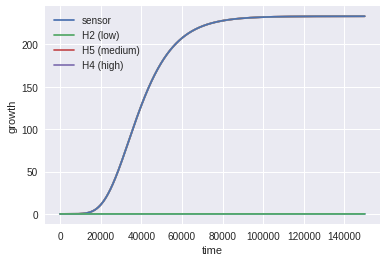

Function test_calculate_next_growth took 10.378490686416626


{'H2 (low)': 21430.795825225257,
 'H4 (high)': 21430.795825225257,
 'H5 (medium)': 21430.795825225257,
 'sensor': 21430.795825225257}

In [ ]:
Grid = Grid_model(grid_dimensions, cell_type_info)
Grid.test_calculate_next_growth(150000)
Grid.log_mew_max
Grid.log_lam

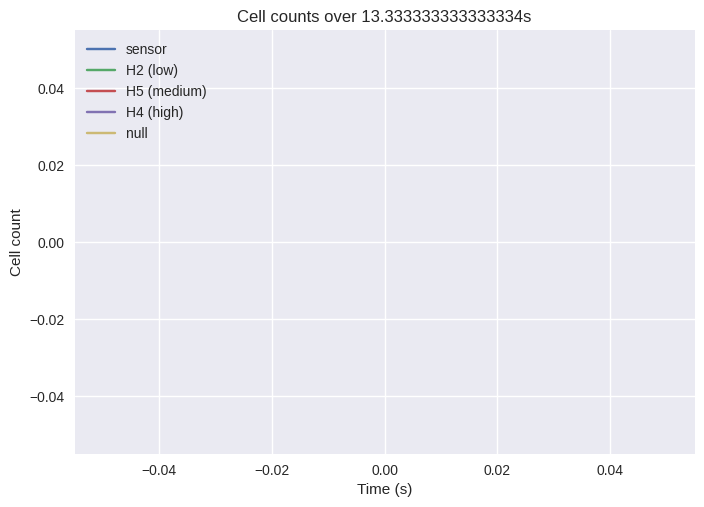

{'H2 (low)': [[10092, 10092],
  [13261, 13261],
  [9893, 9893],
  [14637, 14637],
  [11529, 11529],
  [10985, 10985],
  [13612, 13612]],
 'H4 (high)': [[12169, 12169],
  [13283, 13283],
  [12527, 12527],
  [16731, 16731],
  [13053, 13053],
  [12888, 12888],
  [9313, 9313]],
 'H5 (medium)': [[11335, 11335],
  [9537, 9537],
  [11095, 11095],
  [12665, 12665],
  [9216, 9216],
  [11844, 11844],
  [9476, 9476]],
 'null': [[63795275, 63795275],
  [63787047, 63787047],
  [63789849, 63789849],
  [63778613, 63778613],
  [63795502, 63795502],
  [63788945, 63788945],
  [63795921, 63795921]],
 'sensor': [[11129, 11129],
  [16872, 16872],
  [16636, 16636],
  [17354, 17354],
  [10700, 10700],
  [15338, 15338],
  [11678, 11678]]}

<Figure size 800x550 with 0 Axes>

In [ ]:
Grid.plot_cell_counts(2, all_seeds=True)
Grid.total_cell_counts

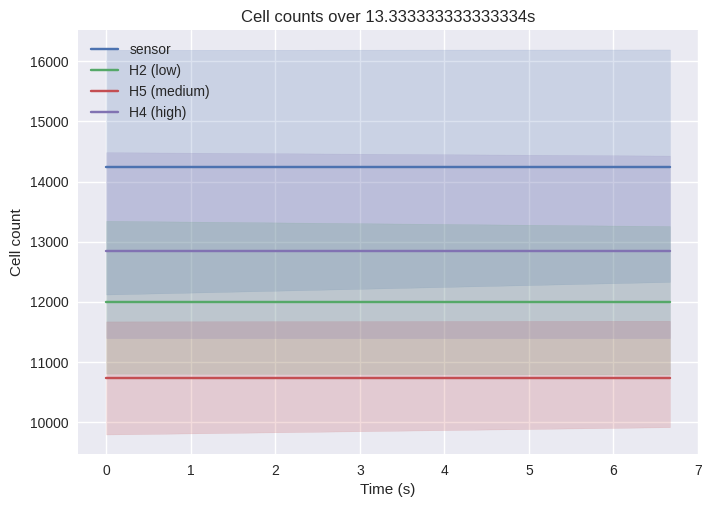

In [ ]:
# plot_cell_counts(self
# Grid = Grid_model(grid_dimensions, cell_type_info)
# Grid.initialise_world(0)
# Grid.total_cell_counts = {k: [[0*np.random.rand(1)[0], 1*np.random.rand(1)[0], 5*np.random.rand(1)[0], 3*np.random.rand(1)[0]] for k in range(len(Grid.cell_seed))] for k in Grid.all_identities.keys()}
# Grid.plot_cell_counts(3, all_seeds=True)



tot_time = 2

x = pd.DataFrame()

cell_type = list(self.cell_identities.keys())[0]
time_line = [(np.arange(tot_time) * Grid.dt * Grid.time_dilation) for k in range(len(Grid.cell_seed))]
time_line = np.array(time_line)
time_line = time_line.flatten()
x['Time'] = time_line
seeds = [np.ones(len(Grid.total_cell_counts[cell_type][0])) * i for i in range(len(Grid.total_cell_counts[cell_type]))]
seeds = np.array(seeds)
seeds = seeds.flatten()
x['Seeds'] = seeds
for cell_type in Grid.all_identities.keys():
    b = np.array(Grid.total_cell_counts[cell_type])
    b = b.flatten()
    x[cell_type] = b

# for i, cell_type in enumerate(Grid.all_identities.keys()):
#     if cell_type == 'null':
#         continue
    
#     sns.lineplot(data=x, x="Time", y=cell_type, label=cell_type)
#     plt.legend(loc='upper left')


all_seeds = True


# plt.style.use('seaborn')

self = Grid
if all_seeds:
#     x = pd.DataFrame()

#     cell_type = list(self.cell_identities.keys())[0]
#     time_line = [(np.arange(tot_time) * self.dt * self.time_dilation) for k in range(len(self.cell_seed))]
#     time_line = np.array(time_line)
#     time_line = time_line.flatten()
    x['Time'] = time_line
#     seeds = [np.ones(len(self.total_cell_counts[cell_type][0])) * i for i in range(len(self.total_cell_counts[cell_type]))]
#     seeds = np.array(seeds)
#     seeds = seeds.flatten()
#     x['Seeds'] = seeds

#     for cell_type in self.all_identities.keys():
#         b = np.array(self.total_cell_counts[cell_type])
#         b = b.flatten()
#         x[cell_type] = b

    for cell_type in self.all_identities.keys():
        if cell_type == 'null':
            continue
        sns.lineplot(data=x, x="Time", y=cell_type, label=cell_type)

else:
    for cell_type in self.all_identities.keys():
        if cell_type == 'null':
            continue
        plt.plot((np.arange(tot_time) * self.dt * self.time_dilation), self.total_cell_counts[cell_type][seed_iter], label=str(cell_type))

plt.title("Cell counts over {}s".format(tot_time * self.dt * self.time_dilation))
plt.xlabel('Time (s)')
plt.ylabel('Cell count')
plt.legend(loc='upper left')
plt.show()
# plt.savefig(self.fig_name_cell_counts)
        


In [ ]:
t = Grid.total_cell_counts

{'H2 (low)': [[], [], [], [], [], [], []],
 'H4 (high)': [[], [], [], [], [], [], []],
 'H5 (medium)': [[], [], [], [], [], [], []],
 'null': [[], [], [], [], [], [], []],
 'sensor': [[], [], [], [], [], [], []]}

In [ ]:
for cell_type in Grid.cell_identities:
    print(Grid.log_phase_step_deriv(cell_type, Grid.time_steps_taken)/Grid.log_mew_max[cell_type])

2.076974162148575e-13
2.076974162148575e-13
2.076974162148575e-13
2.076974162148575e-13


In [ ]:
# Grid.play_gif()
from IPython.display import Image as pyImage

fname = Grid.gif_save_name
pyImage(open(fname,'rb').read())


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

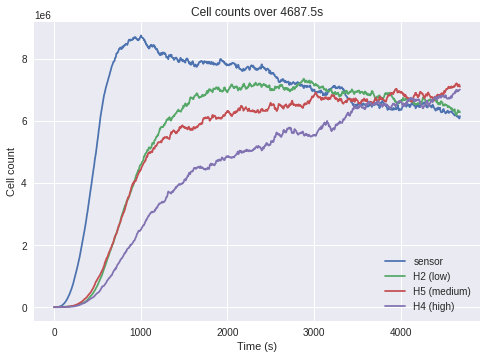

In [ ]:
Grid.plot_cell_counts(1000)

In [ ]:
cell_type = [k for k in Grid.cell_identities.keys()]
Grid.p_division_init = Grid.log_phase_step_deriv(cell_type[0], Grid.time_steps_taken)/Grid.log_mew_max[cell_type[0]]
Grid.p_division_init
Grid.time_steps_taken
Grid.log_phase_step_deriv(cell_type[0], Grid.time_steps_taken)

2.8842352370550924e-19

In [ ]:
for cell_type in Grid.cell_identities.keys():
    gluc_locs = np.where(Grid.molecules_grid['glucose'] == 0)
    # print(type(Grid.p_division[cell_type]))
    # print(Grid.p_division[cell_type][gluc_locs])

np.shape(np.zeros(np.shape(Grid.molecules_grid['glucose'])))
np.shape(Grid.molecules_grid['glucose'])

(300, 300)

In [ ]:
#@title Tests
# cell density add up to 1
arrays = Grid.history
[Grid.visualise_grid(arrays[i], show=False) for i in range(len(arrays))]

[]

# Helper blocks

In [ ]:
!pip install casadi

In [ ]:
!pip install perlin_noise

In [ ]:
!pip install noise

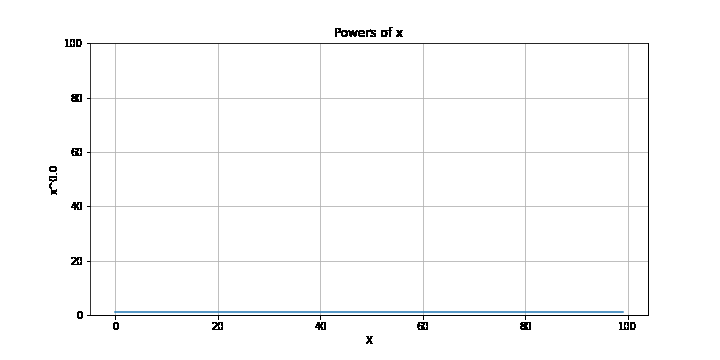

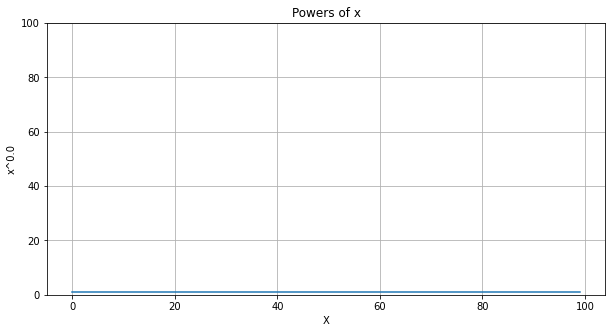

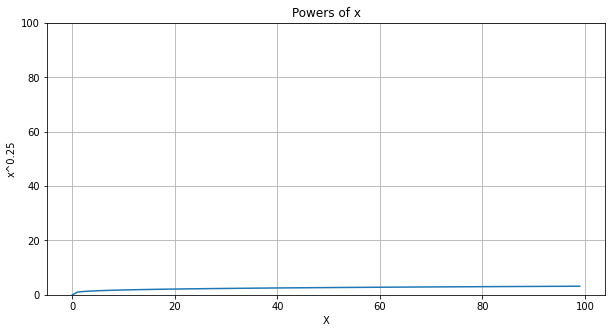

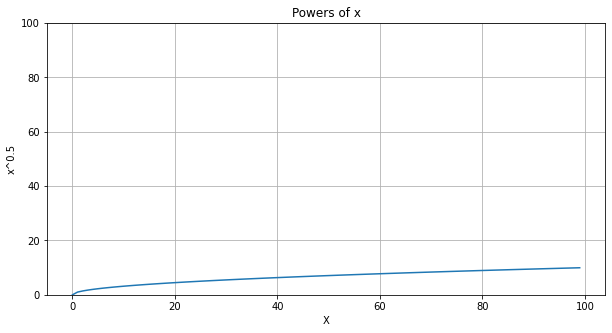

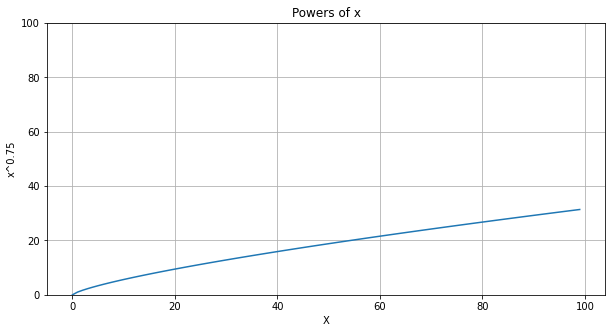

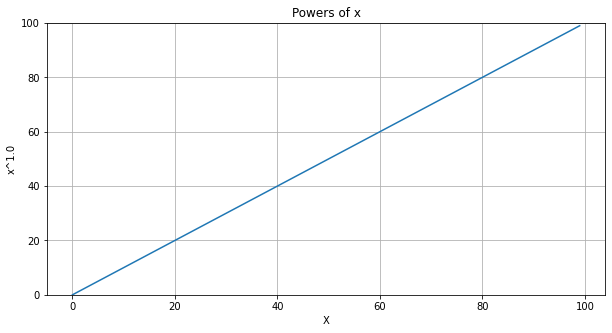

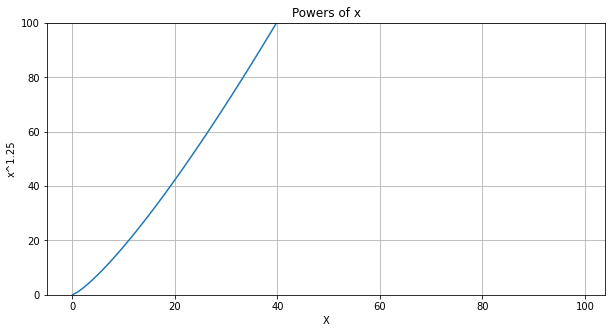

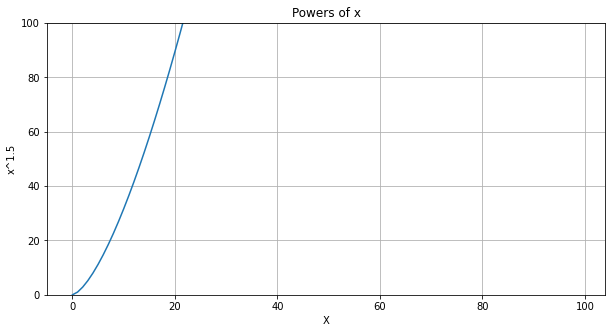

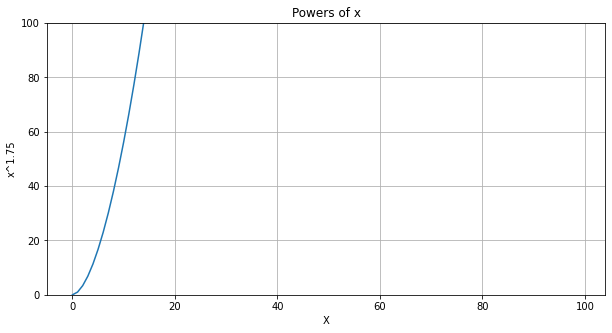

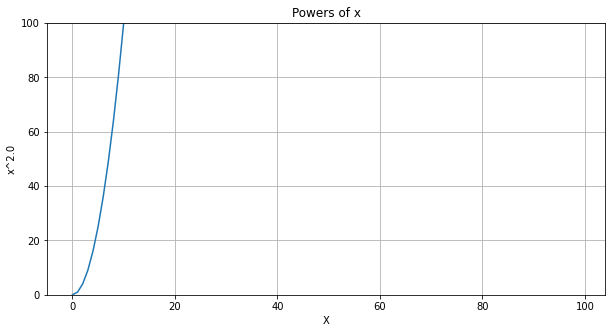

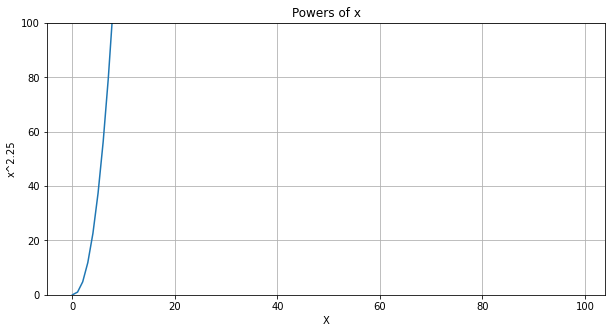

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import imageio

def plot_for_offset(power, y_max):
    # Data for plotting
    t = np.arange(0.0, 100, 1)
    s = t**power

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(t, s)
    ax.grid()
    ax.set(xlabel='X', ylabel='x^{}'.format(power),
           title='Powers of x')

    # IMPORTANT ANIMATION CODE HERE
    # Used to keep the limits constant
    ax.set_ylim(0, y_max)

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('./powers.gif', [plot_for_offset(i/4, 100) for i in range(10)], fps=1)

from IPython.display import Image
Image(open('./powers.gif','rb').read())

In [ ]:
from copy import deepcopy
            

cell_id = 0

img_raw = deepcopy(Grid.cell_grid)
img_raw[img_raw != cell_id] = Grid.null_identity

# define "next to" - this may be a square, diamond, etc
neighborhood = skimage.morphology.disk(radius=1)

min = (skimage.filters.rank.minimum(img_raw, neighborhood) == cell_id)
max = (skimage.filters.rank.maximum(img_raw, neighborhood) == Grid.null_identity)
neighbors = min & max

neighbor_idxs = np.array(np.where(neighbors != False))
num_neighbors = np.shape(neighbor_idxs)[1]
idxs = np.random.choice(np.arange(num_neighbors), size=int((1-Grid.p_division) * num_neighbors), replace=False)
neighbor_idxs = neighbor_idxs[:, idxs]

neighbors[neighbor_idxs[0,:], neighbor_idxs[1,:]] = False

img_raw[neighbors] = cell_id

Visualising...


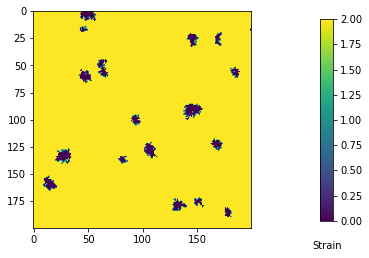

In [ ]:
Grid.visualise_grid(img_raw)

In [ ]:
"""Writes a 256x256 grayscale simplex noise texture file in pgm format
(see http://netpbm.sourceforge.net/doc/pgm.html)
"""
# $Id: 2dtexture.py 21 2008-05-21 07:52:29Z casey.duncan $

import sys
from noise import pnoise2, snoise2

if len(sys.argv) not in (2, 3) or '--help' in sys.argv or '-h' in sys.argv:
	print('2dtexture.py FILE [OCTAVES]')
	print()
	print(__doc__)
	raise SystemExit

f = open(sys.argv[1], 'wt')
# if len(sys.argv) > 2:
# 	octaves = int(sys.argv[2])
# else:
octaves = 1
freq = 16.0 * octaves
f.write('P2\n')
f.write('256 256\n')
f.write('255\n')
for y in range(256):
	for x in range(256):
		f.write("%s\n" % int(snoise2(x / freq, y / freq, octaves) * 127.0 + 128.0))
f.close()

0 1
100 2
200 3
300 4
400 5
1000 6


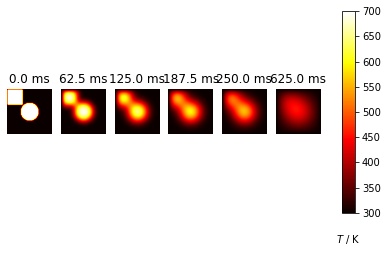

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# plate size, mm
w = h = 10.
# intervals in x-, y- directions, mm
dx = dy = 0.1
# Thermal diffusivity of steel, mm2.s-1
D = 4.

Tcool, Thot = 300, 700

nx, ny = int(w/dx), int(h/dy)

dx2, dy2 = dx*dx, dy*dy
dt = dx2 * dy2 / (2 * D * (dx2 + dy2))

u0 = Tcool * np.ones((nx, ny))
u = u0.copy()

# Initial conditions - circle of radius r centred at (cx,cy) (mm)
r, cx, cy = 2, 5, 5
r2 = r**2
for i in range(nx):
    for j in range(ny):
        p2 = (i*dx-cx)**2 + (j*dy-cy)**2
        if p2 < r2:
            u0[i,j] = Thot
u0[0:35, 0:35] = Thot

def do_timestep(u0, u):
    # Propagate with forward-difference in time, central-difference in space
    u[1:-1, 1:-1] = u0[1:-1, 1:-1] + D * dt * (
          (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])/dx2
          + (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])/dy2 )

    u0 = u.copy()
    return u0, u

# Number of timesteps
nsteps = 1001
# Output 4 figures at these timesteps
mfig = [0, 100, 200, 300, 400, 1000]
subplot_num = int('1' + str(len(mfig)) + '0')
fignum = 0
fig = plt.figure()
for m in range(nsteps):
    u0, u = do_timestep(u0, u)
    if m in mfig:
        fignum += 1
        print(m, fignum)
        ax = fig.add_subplot(subplot_num + fignum)
        im = ax.imshow(u.copy(), cmap=plt.get_cmap('hot'), vmin=Tcool,vmax=Thot)
        ax.set_axis_off()
        ax.set_title('{:.1f} ms'.format(m*dt*1000))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar_ax.set_xlabel('$T$ / K', labelpad=20)
fig.colorbar(im, cax=cbar_ax)
plt.show()

In [ ]:
u[0,0]

300.0

In [ ]:
import matplotlib.pyplot as plt
from perlin_noise import PerlinNoise
import numpy as np

noise1 = PerlinNoise(octaves=4, seed=1)
noise2 = PerlinNoise(octaves=8, seed=1)
noise3 = PerlinNoise(octaves=16, seed=1)
xpix, ypix, zpix = 200, 200, 2
# pic = [[[noise([i/xpix, j/ypix, k/zpix]) for j in range(xpix)] for i in range(ypix)] for k in range(zpix)]
pic1 = [[noise1([i/xpix, j/ypix]) for j in range(xpix)] for i in range(ypix)]
pic2 = [[0.5 * noise2([i/xpix, j/ypix]) for j in range(xpix)] for i in range(ypix)]
pic3 = [[0.25 * noise3([i/xpix, j/ypix]) for j in range(xpix)] for i in range(ypix)]
pic = np.add(pic1, pic2)
pic = np.add(pic, pic3)

plt.imshow(pic[:][:], cmap='gray')
plt.show()



In [ ]:
from casadi import *
import matplotlib.pyplot as plt


x = MX.sym('x',2); # Two states
p = MX.sym('p');   # Free parameter

# Expression for ODE right-hand side
z = 1-x[1]**2;
rhs = vertcat(z*x[0]-x[1]+2*tanh(p),x[0])

# ODE declaration with free parameter
ode = {'x':x,'p':p,'ode':rhs}

# Construct a Function that integrates over 1s
F = integrator('F','cvodes',ode,{'tf':1})

# Control vector
u = MX.sym('u',4,1)

x = [0,1]  # Initial state
for k in range(4):
  # Integrate 1s forward in time:
  # call integrator symbolically
  res = F(x0=x,p=u[k])
  x = res["xf"]


# NLP declaration
nlp = {'x':u,'f':dot(u,u),'g':x};

# Solve using IPOPT
solver = nlpsol('solver','ipopt',nlp)
res = solver(x0=0.2,lbg=0,ubg=0)

plt.plot(res["x"])

In [ ]:
import networkx as nx

# Creating a Graph 
G = nx.Graph() # Right now G is empty

# Add a node
G.add_node(1) 
G.add_nodes_from([2,3]) # You can also add a list of nodes by passing a list argument

# Add edges 
G.add_edge(1,2)

e = (2,3)
G.add_edge(*e) # * unpacks the tuple
G.add_edges_from([(1,2), (1,3)]) # Just like nodes we can add edges from a list

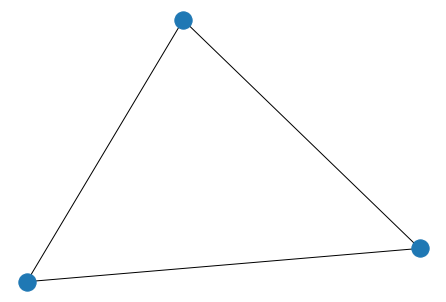

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
nx.draw(G)

In [ ]:
# https://stackoverflow.com/questions/52859983/interactive-matplotlib-figures-in-google-colab
import datetime
from datetime import date
import pandas as pd
import numpy as np
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()


init_notebook_mode(connected=False)


def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
  


df = pd.DataFrame({
    'month': ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
    'Year_2018': [3.26, 6.11, 4.86, 6.53, 4.45, 3.86, 8.04, 7.59, 1.48, 4.75, 7.27, 11.83],
    'Year_1996': [8.26, 3.82, 6.42, 2.91, 2.12, 1.70, 2.14, 4.66, 4.32, 0.89, 3.22, 4.14]
}
)

configure_plotly_browser_state()
df.iplot(kind='line',x='month',y=['Year_2018', 'Year_1996'], color=['white', 'gold'], 
theme='solar', mode='markers+lines',title='Annual Rainfall in the city Peachtree City, GA')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Old code

In [ ]:
# Old code from Grid_model class

    def take_growth_step(self):
        """ Obsolete """
        old_grid = self.cell_grid

        for x in range(1, self.grid_dimensions[0]-1):   # Do -2 instead of -1
            for y in range(1, self.grid_dimensions[1]-1):
                current_cell_id = old_grid[x, y]
                if current_cell_id == self.null_identity:
                    continue
                neighbors = old_grid[x-1:x+2, y-1:y+2]
                free_neighbors = np.array(np.where(neighbors == self.null_identity))
                
                if free_neighbors.size > 0:
                    random_choice = np.random.choice(np.shape(free_neighbors)[1], replace=False)
                    random_neighbor_x, random_neighbor_y = free_neighbors[:, random_choice]
                    random_neighbor_x, random_neighbor_y = random_neighbor_x-1, random_neighbor_y-1
                    if self.p_division > np.random.rand():
                        self.cell_grid[x+random_neighbor_x, y+random_neighbor_y] = current_cell_id
                else:
                    if self.p_starvation > np.random.rand():
                        self.cell_grid[x,y] = self.null_identity
                
                old_grid = self.cell_grid

    def take_growth_step_2(self):
        """ Determine cells to grow and die """
        # define "next to" - this may be a square, diamond, etc
        neighborhood = skimage.morphology.disk(radius=1)
        
        # Free neighbors
        for cell_id in self.cell_ids:
            img_raw = deepcopy(self.cell_grid)
            img_raw[img_raw != cell_id] = self.null_identity

            # define "next to" - this may be a square, diamond, etc
            neighborhood = skimage.morphology.disk(radius=1)

            min = (skimage.filters.rank.minimum(img_raw, neighborhood) == cell_id)
            max = (skimage.filters.rank.maximum(img_raw, neighborhood) == self.null_identity)
            neighbors = min & max

            neighbor_idxs = np.array(np.where(neighbors != False))
            num_neighbors = np.shape(neighbor_idxs)[1]
            idxs = np.random.choice(np.arange(num_neighbors), size=int((1-self.p_division_init) * num_neighbors), replace=False)
            neighbor_idxs = neighbor_idxs[:, idxs]

            neighbors[neighbor_idxs[0,:], neighbor_idxs[1,:]] = False

            self.cell_grid[neighbors] = cell_id

In [ ]:
# grid = Grid.cell_grid

# title_text='k'
# opt_text=''
# opt_cbar_text='Strains'
# show=True
# save_name=''
# quantised=True
# opt_cbar_tickers=list(Grid.all_identities.keys())

# plt.style.use('default')

# grid_max = np.max(grid)

# fig = plt.figure()
# ax = fig.add_subplot()
# ax.set_title(opt_text)
# cmap = plt.get_cmap('viridis', num_colors) if quantised else plt.get_cmap('viridis')

# show = True

# fig.subplots_adjust(right=0.85)
# plt.title(title_text)
# im = ax.imshow(grid.copy(), cmap=cmap, norm=norm, vmin=0, vmax=grid_max)
# cbar = fig.colorbar(im)
# if quantised:
#     num_colors = grid_max+1
#     bounds = np.array(range(0, num_colors)) * (1-1/grid_max)
#     cbar.set_ticks(np.array(bounds)+0.5)
#     tick_texts = cbar.ax.set_yticklabels(opt_cbar_tickers)
#     tick_texts[0].set_verticalalignment('top')
#     tick_texts[-1].set_verticalalignment('bottom')
# cbar.ax.set_xlabel(opt_cbar_text, labelpad=20)

# if show:
#     print('Visualising...')
#     plt.show()
# else:
#     plt.savefig('./{}/{}'.format(self.gif_directory, save_name))
#     plt.close(fig)
